In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
#import matplotlib; matplotlib.use('Agg')
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors_test as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re
import acceptance_psf_eastrogam as aaa
import photon_spectrum
import evaporating_black_hole_template as dm_template

In [2]:
filelist1 = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
filelist = ['bremss_healpix_reshuffled_61templates.fits', 'bremss_healpix_reshuffled_61templates.fits', 'pi0_decay_healpix_reshuffled_61templates.fits', 'pi0_decay_healpix_reshuffled_61templates.fits', 'ics_isotropic_healpix_reshuffled_61templates.fits', 'ics_isotropic_healpix_reshuffled_61templates.fits']
evermore_shifted = np.asarray([
    [33, 21, 49],
    [154, 112, 82],
    [241, 149, 91],
    [142, 52, 38],
    [33, 21, 49],
])/256

point_sources = ['Pointsources_central_23deg_61energybins.fits']

#exposure_time = 4.1e6 #.13 years 47 days
exposure_time = 4.1e8 #13 years
#exposure_time = 4.1e9 #130 years
#exposure_time = 4.1e11 #13000 years
#exposure_time = 4.1e16 #13000 years
#exposure_time = 3.154e10

acceptance_interp = aaa.get_acceptance_interp() #put in the energy in MeV!
angle_interp = aaa.get_angle_interp()

central_energies = np.array([1.22474487e+00, 1.54186244e+00, 1.94108981e+00, 2.44368729e+00,
       3.07642002e+00, 3.87298335e+00, 4.87579715e+00, 6.13826494e+00,
       7.72761772e+00, 9.72849432e+00, 1.22474487e+01, 1.54186244e+01,
       1.94108981e+01, 2.44368729e+01, 3.07642002e+01, 3.87298335e+01,
       4.87579715e+01, 6.13826494e+01, 7.72761772e+01, 9.72849432e+01,
       1.22474487e+02, 1.54186244e+02, 1.94108981e+02, 2.44368729e+02,
       3.07642002e+02, 3.87298335e+02, 4.87579715e+02, 6.13826494e+02,
       7.72761772e+02, 9.72849432e+02, 1.22474487e+03, 1.54186244e+03,
       1.94108981e+03, 2.44368729e+03, 3.07642002e+03, 3.87298335e+03,
       4.87579715e+03, 6.13826494e+03, 7.72761772e+03, 9.72849432e+03,
       1.22474487e+04, 1.54186244e+04, 1.94108981e+04, 2.44368729e+04,
       3.07642002e+04, 3.87298335e+04, 4.87579715e+04, 6.13826494e+04,
       7.72761772e+04, 9.72849432e+04, 1.22474487e+05, 1.54186244e+05,
       1.94108981e+05, 2.44368729e+05, 3.07642002e+05, 3.87298335e+05,
       4.87579715e+05, 6.13826494e+05, 7.72761772e+05, 9.72849431e+05,
       1.22474487e+06])




In [4]:
#Egammas for evaporating black holes
energiesforBH = np.logspace(np.log10(.05), np.log10(1e7), num = 1000)
egamma_values = photon_spectrum.get_egammas(energiesforBH)


In [5]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    hdu1 = readfile(filelist1[0])
    
    if inner20:
        numpix = np.linspace(0, hdu1[0].header['NPIX']-1, num = hdu1[0].header['NPIX'])
        NSIDE = int(hdu1[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        vec = hp.ang2vec(np.pi/2, 0)
        ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)[ipix_disc20]
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu1[0].header['NPIX']-1, num = hdu1[0].header['NPIX'])
        NSIDE = int(hdu1[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #print(sum(~np.isnan(test20)))
        #testbin = np.reshape(test20, (128*3, 1536//3))
        
    return test20

def get_energy_index(E_desired):
    idx = find_nearest(central_energies, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

In [6]:
brem = readfile(filelist[0])
print(brem[35].data)


[1.72176464e-12 1.84447526e-12 1.87079346e-12 ... 2.69754590e-12
 2.86177782e-12 2.83455527e-12]


In [7]:


def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(3, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 400)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str


In [8]:
def subtract(n):
    ##Template for 1 GeV and 10 GeV
    icsa = readfile(filelist[n])
    
    idx1 = get_energy_index(1*1e3, icsa)
    idx10 = get_energy_index(10*1e3, icsa)
    
    array1 = reshape_file(icsa, idx1, inner20 = False)
    array10 = reshape_file(icsa, idx10, inner20 = False)
    
    ##Sum up idx1 and idx 10, make them equal in sum
    sum1 = np.nansum(array1)
    sum10 = np.nansum(array10)
    array10_adjusted = (array10*sum1/sum10)
    subtract110 = np.abs(array1-array10_adjusted)/array1
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(subtract110)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    plt.title(str(filelist[n]))
    
    return

In [9]:


#n = 4 for ICSA, n = 2 for pi0
def psf_smoothing(n, energyidx, inner20psf = False, pointsource = False, use_og = False):
    inner20psf = False
    if pointsource:
        icsa = readfile(point_sources[0])
        data50 = icsa[energyidx].data
    else:
        icsa = readfile(filelist[n])
        data50 = reshape_file(icsa, energyidx, inner20 = inner20psf)
    hdu = readfile(filelist1[0])

    #data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at 50 MeV
    
    #get_where_within_20deg
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    init_sum = np.sum(data50[ipix_disc])
    #print(init_sum)
    energy_here = float(central_energies[energyidx])
    sig = np.pi/180*angle_interp(energy_here)
    if use_og:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=np.pi/180/1.508)
    else:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=sig)

    fin_sum = np.sum(data50_convolved[ipix_disc])
    #print(fin_sum)
    

    #data50_convolved = gaussian_filter(data50, sigma=0)
    
    #only get data within 20 degrees
    #hp.mollview(np.log10(data50_convolved), coord = 'G')
    
    
    testbin = data50_convolved[ipix_disc]
    #print(len(testbin))
    
    #print(init_sum)
    #print(fin_sum)
    #print('---------------')


    return np.array(testbin)*init_sum/fin_sum

def psf_smoothing_DM(energyidx, crosssec = 1.4e-26, anal_data = False, mass_dm = 40, use_og = False, evapbh = False, gam = 1, massbh = 2e16):
    energybin = central_energies[energyidx]
    bins_in_lin = np.log10(energybin)
    deltae = get_deltaE(energyidx)
    
    highe = (energybin+deltae)/1e3
    lowe = (energybin-deltae)/1e3
    
    hdu = readfile(filelist1[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    
    
    #need to make sure the initsum is *only within the inner 20 degrees, same for finsum
    if evapbh == True:
        data50 = dm_template.get_dNdE(egamma_values, energyidx, gamma = gam, mass = massbh, for_normals = False) #photons per cm^2 per sec per str per MeV
    else:
        data50 = dmj.get_dNdE(highe, lowe, sigmav = crosssec, analyze_data = anal_data, massx = mass_dm)[1] #photons per cm^2 per sec per str per MeV
    
    #get_where_within_20deg
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    init_sum = np.sum(data50[ipix_disc])
    #print('init sum: {}'.format(init_sum))
    
    energy_here = float(hdu[38].data[energyidx][0])
    sig = np.pi/180*angle_interp(energy_here)
    if use_og:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=np.pi/180/1.508)
    else:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=sig)
    fin_sum = np.sum(data50_convolved[ipix_disc])
    
    #hp.mollview((data50_convolved), coord = 'G')
    
    #photons per cm^2 per sec per str per MeV
    
    #print(init_sum)
    #print(fin_sum)
    #print('---------------')
    
    return np.array(data50_convolved[ipix_disc])*init_sum/fin_sum

def get_deltaE(n):
    energybins = central_energies
    bins_in_lin = np.log10(energybins)[n]
    #spacing = 0.05691431 #old spacing
    spacing = 0.17609125905568124 #new spacing
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return deltaE


In [10]:
psf_smoothing(0, 34)


array([7.89721335e-11, 7.64789098e-11, 6.59042558e-11, ...,
       3.26272571e-11, 3.67162333e-11, 6.02508637e-11])

In [11]:
#here1 = psf_smoothing_DM(10, evapbh = True, gam = 1, massbh = 1e16)

#here1 = psf_smoothing_DM(15, crosssec = 2.2e-24, mass_dm = 100, gam = 1, massbh = 2e16)



In [12]:
"""
indexhere = 10
psf_smoothing_DM(indexhere, crosssec = 1e-25)
psf_smoothing_DM(indexhere, crosssec = 1e-25, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(0, indexhere)
psf_smoothing(0, indexhere, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(2, indexhere)
psf_smoothing(2, indexhere, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(4, indexhere)
psf_smoothing(4, indexhere, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(np.nan, indexhere, pointsource = True)
psf_smoothing(np.nan, indexhere, pointsource = True, use_og = True)
"""

"\nindexhere = 10\npsf_smoothing_DM(indexhere, crosssec = 1e-25)\npsf_smoothing_DM(indexhere, crosssec = 1e-25, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(0, indexhere)\npsf_smoothing(0, indexhere, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(2, indexhere)\npsf_smoothing(2, indexhere, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(4, indexhere)\npsf_smoothing(4, indexhere, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(np.nan, indexhere, pointsource = True)\npsf_smoothing(np.nan, indexhere, pointsource = True, use_og = True)\n"

In [13]:


def poisson_dist(n, energyidx, cross_section =1.4e-26, dm = False, dm_bh = False, analyze_data = False, dm_mass = 40, egb = False, points = False, counts = 0, evapbh = True, blackholem = 2e16):   
    '''
    Performs a PSF smoothing of the array, before converting it into photons per pixel
    
    '''
    deltaE = get_deltaE(energyidx)
    print(deltaE)
    energy_here = central_energies[energyidx]
    print(energy_here)
    acceptance_for_poisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    
    if dm:
        convolved_data = psf_smoothing_DM(energyidx, cross_section, anal_data = analyze_data, mass_dm = dm_mass)/deltaE
    elif egb:
        convolved_data_init = np.empty(5938) #needs to be the length of the good vals
        convolved_data_init.fill(1) #counts per cm^2 per sec per str
        convolved_data = convolved_data_init*counts #in units of photons per cm^2 per mev per str per sec
    elif points:
        convolved_data = psf_smoothing(n, energyidx, pointsource = True)
    elif dm_bh:
        convolved_data = psf_smoothing_DM(energyidx, cross_section, anal_data = analyze_data, evapbh = True, massbh = blackholem)
    else:
        convolved_data = psf_smoothing(n, energyidx, cross_section) #data in units of photons cm^-2 MeV^-1 str^-1
    #n_gamma = np.array(convolved_data)*deltaE*exposure_time*8500*4*np.pi/196608*.2 #13 years*.85meters^2, units of photons per pixel
    n_gamma = np.array(convolved_data)*deltaE*exposure_time*acceptance_for_poisson/196608 #13 years*.85meters^2, units of photons per pixel

    
    return n_gamma


In [14]:
"""
indexhere = 7

poisson_dist(np.nan, indexhere, cross_section =1e-25, dm = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(0, indexhere, cross_section =1e-25)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(2, indexhere, cross_section =1e-25)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(4, indexhere, cross_section =1e-25)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(np.nan, indexhere, cross_section =1e-25, points = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(np.nan, indexhere, cross_section =1e-25, egb = True, counts = egb_counts[indexhere-3])
"""




"\nindexhere = 7\n\npoisson_dist(np.nan, indexhere, cross_section =1e-25, dm = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(0, indexhere, cross_section =1e-25)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(2, indexhere, cross_section =1e-25)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(4, indexhere, cross_section =1e-25)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(np.nan, indexhere, cross_section =1e-25, points = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(np.nan, indexhere, cross_section =1e-25, egb = True, counts = egb_counts[indexhere-3])\n"

In [15]:




def get_image(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(data)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    return

def simulated_data(energyidx, templates):
    
    '''
    Use PSF smoothed data to create a random poisson draw to obtain simulated data
    '''
    
    
    n_gammatot = 0
    for i in range(0, len(templates)):
        n_gammatot += templates[i]
    len_of_rand = len(n_gammatot)
    simdata = np.zeros(len_of_rand)
    randdata = np.random.rand(len_of_rand)
    
    #print(n_gammatot)
    
    for i in range(0, len_of_rand):
        #print(n_gammatot[i])
        if n_gammatot[i]<.01:
            if n_gammatot[i] < randdata[i]:
                simdata[i] = 0
            else:
                simdata[i] = 1
        else:
            simdata[i] = np.random.poisson(lam = n_gammatot[i])
    #print('simdata just 20: ', np.nansum(simdata))
    
    return simdata

def minimize_likelihood(energyidx, cross_sec = 1.4e-26, massdm = 40):
    pi = poisson_dist(2, energyidx)
    ics = poisson_dist(4, energyidx)   
    brem = poisson_dist(0, energyidx)

    darkm = poisson_dist(np.nan, energyidx, cross_section = cross_sec, dm = True, dm_mass = massdm)

    k = simulated_data(energyidx, [pi, ics, brem])#remove DM for accurate
    #print(np.nanmean(lamb))
    #asdfasd
    
    #Need to minimize for lamb < 50 and lamb > 50
    
    bnds = ((0, np.inf), (0, np.inf), (0, np.inf), (1e-30, np.inf))
    result = minimize(likelihood, (1, 1, 1, 1), args = (k, pi, ics, brem, darkm), bounds = bnds)
    min_likelihood = result.x
    chi2 = result.fun
    #print(result)

    return min_likelihood


def likelihood(constants, k, pi, ics, brem, dm):
    """
    Gets the Total Likelihoods from the Gaussian Regime and the Poisson Regime
    Once each has been calculated, multiplies values together for final likelihood
    """
    
    likelihood_poiss = likelihood_poisson(constants, k, pi, ics, brem, dm)
    #print('likelihood: {}'.format(likelihood_poiss)) 
    return likelihood_poiss

def merge(list1, list2):
      
    merged_list = tuple(zip(list1, list2)) 
    return merged_list

def likelihood_gaussian(constants, lamb, pi, ics):
    sigma = np.sqrt(constants[0]*pi+constants[1]*ics)
    mu = lamb
    rng = 0.5
    
    #flatten arrays
    sigma_flat = sigma.flatten()
    mu_flat = mu.flatten()
    length_flattened = len(mu_flat)
    #get arrays in sigma, mu tuple format
    ms_tuples = list(merge(mu_flat, sigma_flat))
    ms = np.array(ms_tuples, dtype = 'f,f')
    lower_bound_arr = mu_flat - rng
    upper_bound_arr = mu_flat + rng
    
    args = np.concatenate((np.full((length_flattened, 1), prob_func), lower_bound_arr.reshape((length_flattened, 1)), upper_bound_arr.reshape((length_flattened, 1)), ms.reshape((length_flattened, 1))), axis = 1)
    
    #log likelihood
    prob = list(starmap(lambda a, b, c, d: quad(a, b, c, d)[0], args))

    #reshape for testing
    l = np.sum(np.log(prob))
    likely = -2*l
    
    return likely
    
def prob_func(x, mu, sigma):
    probdens = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2*((x-sigma**2)/sigma)**2)
    return probdens

#def likelihood_poisson(a0):
def likelihood_poisson(a0, a1, a2, a3, a4):
#def likelihood_poisson(constants, ktest, pitest, icstest, bremtest, dmtest):
    lamb = a0*pitest+a1*icstest+a2*bremtest+a3*darkmtest+a4*egbtest
    #lamb = a0*egbtest
    
    #print(a0, a1, a2, a3)
    #print(lamb)

    #lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+constants[3]*dmtest
    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    #print(fprob)
    return -2*np.nansum(fprob)

def get_curves_norm(n, energyidx, inner20psf = True):
    icsa = readfile(filelist[n])
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at energyidx MeV
    delt = get_deltaE(energyidx)
    
    hdu = readfile(filelist[0])
    energy_here = central_energies[energyidx]
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    
    return np.asarray(data50)*delt
    #return np.asarray(data50)*exposure_time*acceptance_forpoisson*delt #try to get in terms of counts per bin

def get_curves(n, energyidx, inner20psf = True):
    icsa = readfile(filelist[n])
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at energyidx MeV
    delt = get_deltaE(energyidx)
    
    hdu = readfile(filelist[0])
    energy_here = central_energies[energyidx]
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    
    return np.asarray(data50)*exposure_time*acceptance_forpoisson*delt #try to get in terms of counts per bin
    
    
def get_normalizations_spectrum(deltaE, cross_sec = 1.4e-26, dm_mass = 40, f_bh = 1, gam = 1, massbh = 2e26):
    
    range_templates = [2, 4, 0] #pi, ics, brem
    energies = np.copy(central_energies)
    templates = []
    temp = []
    #deltaomega = 1/196608 #i think this should maybe still be total bins in whole image pre-20?
    deltaomega=1
    acceptances = []
    for energy_here in range(0, len(energies)):
        acceptance_forpoisson = acceptance_interp(energy_here) #in cm^2*str
        acceptances.append(acceptance_forpoisson)
    

    for n in range_templates:
        temp = []
        for index in range(0, len(energies)):
            temp.append(np.nansum(get_curves_norm(n, index))) #units of counts per cm^2 per sec per sr
        templates.append(np.asarray(temp)*deltaomega) #gets counts per bin
    print('finished new templates!!')
    

        
    #dark matter template
    
    
    dm_temp = []
    dm_templates_tot = []
    for index in range(0, len(energies)):
        print(index)
        energybin = energies[index]
        bins_in_lin = np.log10(energybin)
        deltae = get_deltaE(index)
    
        highe = (energybin+deltae)/1e3
        lowe = (energybin-deltae)/1e3
        data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_sec, massx = dm_mass, for_normals = True, energyhere = energybin/1e3)[1]*deltae #units of photons cm^-2 str^-1 per sec
        #need to cut this to be inner 20 degrees
        
        #dm_temp.append(np.nansum(data50))
        dm_temp.append(np.nansum(data50)) #units of photons cm^-2 per sec
        print(np.asarray(dm_temp)/.38/196608)
        print('--------------------------------------')
    dm_templates_tot.append(np.asarray(dm_temp)/.38/196608) #photons per cm^2 per sec per sr, .38 is delta omega
    
    print('DONE WITH  THE DARK MATTER TEMPLATE')
    
    #eavporating black holes
    dmevap_temp = []
    dmevap_tot = []
    for index in range(0, len(energies)):
        print(index)
        energybin = energies[index]
        bins_in_lin = np.log10(energybin)
    
        data50 = dm_template.get_dNdE(egamma_values, index, gamma = gam, mass = massbh, for_normals = True) #units of photons cm^-2 str^-1 per sec
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dmevap_temp.append(np.nansum(data50))#units of photons cm^-2 per sec
        print(np.asarray(dmevap_temp)/.38*f_bh/196608)
        print('--------------------------------------')
    dmevap_tot.append(np.asarray(dmevap_temp)/.38*f_bh/196608) #photons per cm^2 per sec per sr
    
    #return range_templates, energies, [np.array(templates[0]), np.array(templates[1]), np.array(templates[2]), np.array(dmevap_tot)]

    
    
    #EGB template
    egb_templates = np.array(get_all_egb(energies, deltaE)) #units of counts per cm^2 per sec per str
    
    #Point Source Template
    point_source_arr = []
    for index in range(0, len(energies)):
        smaller_index = index
        point_source_arr.append(np.nansum(get_curves_pointsource(index, smaller_index, inner20psf = True))) ##units of photons per cm^2 per sec per sr
    
    
    print('yay!')
        
    #return range_templates, energies, [np.array(templates[0]), np.array(templates[1]), np.array(templates[2]), np.array(egb_temp_fin), np.array(dm_templates_tot), np.array(dmevap_tot)] #counts per pixel
    #return range_templates, energies, [np.array(templates[0]), np.array(templates[1]), np.array(templates[2]), np.array(egb_templates), np.array(point_source_arr), np.array(dm_templates_tot)]

    return range_templates, energies, [np.array(templates[0]), np.array(templates[1]), np.array(templates[2]), np.array(egb_templates), np.array(point_source_arr), np.array(dm_templates_tot), np.array(dmevap_tot)] #counts per pixel
    
def get_curves_pointsource(energyidx, smallindex, inner20psf = True):
    pointsourcedata = readfile(point_sources[0])[smallindex].data
    
    hdu = readfile(filelist1[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
        
    test20 = np.copy(pointsourcedata)[ipix_disc20]
    
    delt = get_deltaE(energyidx)
    
    deltaE = get_deltaE(energyidx)
    hdu = readfile(filelist[0])
    energy_here = central_energies[energyidx]
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    
    return np.asarray(test20)*delt #units of photons per cm^2 per sec per sr
    
    #return np.asarray(test20)*exposure_time*acceptance_forpoisson*delt #13 years * .85 m^2 * .2, return in photons /bin
    
    
def get_normalized(energyidx, normals, template_val, energies):
    '''
    Normalizes the ROI based on the shape the spectrums should have
    
    
    Do not need to use this, as long as you stay consistent across all Fermi data
    for the exposure time and collecting area
    
    '''
    
    poisson_pi = poisson_dist(template_val, int(energyidx)) #units of photons per pixel
    init_sum_pi = np.nansum(poisson_pi)
    #print(np.nansum(init_sum_pi))
    if template_val == 2:
        normval = 0
    if template_val == 4:
        normval = 1
    if template_val == 0:
        normval = 2
    print('normval for pi at 0: {}'.format(normals[normval][energyidx])) 
    print('delta E at 0: {}'.format(get_deltaE(energyidx)))
    normal_pi = normals[normval][energyidx]*get_deltaE(energyidx)
    pitest = poisson_pi*normal_pi/init_sum_pi
    print('normalization: {}'.format(np.nansum(pitest)))
    #print(np.nansum(pitest))
    
    #print('----------------------')
    
    return pitest
    

In [16]:


def get_darksusy_counts():
    x = np.loadtxt('yield_DS_keith40.dat', dtype=str).T
    energies = x[1].astype(np.float)*1e3
    yieldperann = x[2].astype(np.float)/1e3 #convert from per GeV to per MeV
    energybins = np.copy(central_energies)
    
    counts = []
    delta = []
    for n in range(0, len(energybins)):
        
        bins_in_lin = energybins[n]
        deltae = get_deltaE(n)
    
        highe = (bins_in_lin+deltae)
        lowe = (bins_in_lin-deltae)
        
        good_energies = np.where((energies <=highe) & (energies >= lowe))
        
        final_integral = np.trapz(yieldperann[good_energies], x = energies[good_energies])

        counts.append(final_integral)
        delta.append(deltae)
    return np.array(counts), np.array(delta)



def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(0, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 600)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str




In [17]:
importlib.reload(dmj)
importlib.reload(dm_template)

#gets darksusy counts for a specific dark matter mass
counts, deltae = get_darksusy_counts()
#be sure to change the dm mass
temps, energies, normals = get_normalizations_spectrum(deltae, cross_sec = 1.4e-26, f_bh = 4e-4, gam = 1.6, massbh = 2e16)


finished new templates!!
0
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11]
--------------------------------------
1
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11]
--------------------------------------
2
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11]
--------------------------------------
3
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10]
--------------------------------------
4
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10]
--------------------------------------
5
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10 4.62136065e-10]
--------------------------------------
6
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10 4.62136065e-10 8.45965928e-10]
--------------------------------------
7
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2

sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10 4.62136065e-10 8.45965928e-10 1.49966217e-09
 2.45813591e-09 3.86260645e-09 5.89610721e-09 8.77172779e-09
 1.27340558e-08 1.80485552e-08 2.49836920e-08 3.37737038e-08
 4.45801353e-08 5.74586349e-08 7.22840595e-08 8.87757006e-08
 1.06447205e-07 1.24637154e-07 1.42521558e-07 1.59076566e-07
 1.72965987e-07 1.82043439e-07 1.81659773e-07 1.68948205e-07
 1.57510841e-07]
--------------------------------------
29
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10 4.62136065e-10 8.45965928e-10 1.49966217e-09
 2.45813591e-09 3.86260645e-09 5.89610721e-09 8.77172779e-09
 1.27340558e-08 1.80485552e-08 2.49836920e-08 3.37737038e-08
 4.45801353e-08 5.74586349e-08 7.22840595e-08 8.87757006e-08
 1.06447205e-07 1.24637154e-07 1.42521558e-07 1.59076566e-07
 1.72965987e-07 1.82043439e-07 1.81659773e-07 1.68948205e-07
 1.57510841e-07 1.43851272e-0

sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10 4.62136065e-10 8.45965928e-10 1.49966217e-09
 2.45813591e-09 3.86260645e-09 5.89610721e-09 8.77172779e-09
 1.27340558e-08 1.80485552e-08 2.49836920e-08 3.37737038e-08
 4.45801353e-08 5.74586349e-08 7.22840595e-08 8.87757006e-08
 1.06447205e-07 1.24637154e-07 1.42521558e-07 1.59076566e-07
 1.72965987e-07 1.82043439e-07 1.81659773e-07 1.68948205e-07
 1.57510841e-07 1.43851272e-07 1.26501172e-07 1.07060411e-07
 8.70587848e-08 6.78523679e-08 5.02595222e-08 3.51110676e-08
 2.31209871e-08 1.42226179e-08 8.10815683e-09 4.24667491e-09
 2.01411767e-09 8.29448656e-10 2.68083645e-10]
--------------------------------------
43
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10 4.62136065e-10 8.45965928e-10 1.49966217e-09
 2.45813591e-09 3.86260645e-09 5.89610721e-09 8.77172779e-09
 1.27340558e-08 1.80485552e-08 2.49836920e-08 3.37737038e-08

sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-10 4.62136065e-10 8.45965928e-10 1.49966217e-09
 2.45813591e-09 3.86260645e-09 5.89610721e-09 8.77172779e-09
 1.27340558e-08 1.80485552e-08 2.49836920e-08 3.37737038e-08
 4.45801353e-08 5.74586349e-08 7.22840595e-08 8.87757006e-08
 1.06447205e-07 1.24637154e-07 1.42521558e-07 1.59076566e-07
 1.72965987e-07 1.82043439e-07 1.81659773e-07 1.68948205e-07
 1.57510841e-07 1.43851272e-07 1.26501172e-07 1.07060411e-07
 8.70587848e-08 6.78523679e-08 5.02595222e-08 3.51110676e-08
 2.31209871e-08 1.42226179e-08 8.10815683e-09 4.24667491e-09
 2.01411767e-09 8.29448656e-10 2.68083645e-10 5.87887769e-11
 1.49731303e-11 4.07745366e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
--------------------------------------
54
sigmav: 1.4e-26
mass: 40 GeV
[1.44087678e-11 2.98943421e-11 6.06861081e-11 1.28178246e-10
 2.54780024e-1

[2.67043875e-05 3.98264789e-05 5.61356804e-05 6.76909982e-05
 6.58450588e-05 5.03006249e-05]
--------------------------------------
6
gamma  1.6
mass of bh: 2e+16
[2.67043875e-05 3.98264789e-05 5.61356804e-05 6.76909982e-05
 6.58450588e-05 5.03006249e-05 2.89169020e-05]
--------------------------------------
7
gamma  1.6
mass of bh: 2e+16
[2.67043875e-05 3.98264789e-05 5.61356804e-05 6.76909982e-05
 6.58450588e-05 5.03006249e-05 2.89169020e-05 1.17459242e-05]
--------------------------------------
8
gamma  1.6
mass of bh: 2e+16
[2.67043875e-05 3.98264789e-05 5.61356804e-05 6.76909982e-05
 6.58450588e-05 5.03006249e-05 2.89169020e-05 1.17459242e-05
 3.31001533e-06]
--------------------------------------
9
gamma  1.6
mass of bh: 2e+16
[2.67043875e-05 3.98264789e-05 5.61356804e-05 6.76909982e-05
 6.58450588e-05 5.03006249e-05 2.89169020e-05 1.17459242e-05
 3.31001533e-06 6.47464317e-07]
--------------------------------------
10
gamma  1.6
mass of bh: 2e+16
[2.67043875e-05 3.98264789e-05 5

[2.67043875e-005 3.98264789e-005 5.61356804e-005 6.76909982e-005
 6.58450588e-005 5.03006249e-005 2.89169020e-005 1.17459242e-005
 3.31001533e-006 6.47464317e-007 8.27802923e-008 6.30289280e-009
 2.55164284e-010 4.78776595e-012 3.52541169e-014 8.32559865e-017
 4.93665556e-020 5.46069397e-024 7.85630964e-029 9.49486295e-035
 5.66140755e-042 8.73889209e-051 1.59538863e-061 1.33062862e-074
 1.59756166e-090 6.79324766e-110 1.86432263e-133 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
--------------------------------------
30
gamma  1.6
mass of bh: 2e+16
[2.67043875e-005 3.98264789e-005 5.61356804e-005 6.76909982e-005
 6.58450588e-005 5.03006249e-005 2.89169020e-005 1.17459242e-005
 3.31001533e-006 6.47464317e-007 8.27802923e-008 6.30289280e-009
 2.55164284e-010 4.78776595e-012 3.52541169e-014 8.32559865e-017
 4.93665556e-020 5.46069397e-024 7.85630964e-029 9.49486295e-035
 5.66140755e-042 8.73889209e-051 1.59538863e-061 1.33062862e-074
 1.59756166e-090 6.79324766e-110 1.86432263e-133 0

[2.67043875e-005 3.98264789e-005 5.61356804e-005 6.76909982e-005
 6.58450588e-005 5.03006249e-005 2.89169020e-005 1.17459242e-005
 3.31001533e-006 6.47464317e-007 8.27802923e-008 6.30289280e-009
 2.55164284e-010 4.78776595e-012 3.52541169e-014 8.32559865e-017
 4.93665556e-020 5.46069397e-024 7.85630964e-029 9.49486295e-035
 5.66140755e-042 8.73889209e-051 1.59538863e-061 1.33062862e-074
 1.59756166e-090 6.79324766e-110 1.86432263e-133 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]
--------------------------------------
43
gamma  1.6
mass of bh: 2e+16
[2.67043875e-005 3.98264789e-005 5.61356804e-005 6.76909982e-005
 6.58450588e-005 5.03006249e-005 2.89169020e-005 1.17459242e-005
 3.31001533e-006 6.47464317e-007 8.27802923e-008 6.30289280e-009
 2.55164284e-010 4.78776595e-012 3

[2.67043875e-005 3.98264789e-005 5.61356804e-005 6.76909982e-005
 6.58450588e-005 5.03006249e-005 2.89169020e-005 1.17459242e-005
 3.31001533e-006 6.47464317e-007 8.27802923e-008 6.30289280e-009
 2.55164284e-010 4.78776595e-012 3.52541169e-014 8.32559865e-017
 4.93665556e-020 5.46069397e-024 7.85630964e-029 9.49486295e-035
 5.66140755e-042 8.73889209e-051 1.59538863e-061 1.33062862e-074
 1.59756166e-090 6.79324766e-110 1.86432263e-133 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
--------------------------------------
53
gamma  1.6
mass of bh: 2e+16
[2.67043875e-005 3.98264789e-005 5.61356804e-005 6.76909982e-005
 

yay!


In [30]:
print(deltae[30:40])

[1020.620725   1284.88536667 1617.57484167 2036.406075   2563.68335
 3227.486125   4063.16429167 5115.22078333 6439.68143333 8107.0786    ]


In [31]:

acceptances = []
cut_energy = energies
for energyidx in range(0, len(cut_energy)):

    energy_here =central_energies[energyidx]
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson)
    

In [83]:
print(normals[5][30])

IndexError: index 30 is out of bounds for axis 0 with size 1

In [75]:
print(normals[5]/deltae*energies**2)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31617206e+00
  6.10971719e+00 1.59981390e+01 3.52622588e+01 7.12742915e+01
  1.36400719e+02 2.50853653e+02 4.46827842e+02 7.74334526e+02
  1.30908569e+03 2.16067489e+03 3.45718666e+03 5.41835925e+03
  8.32346148e+03 1.25303985e+04 1.84805331e+04 2.66654867e+04
  3.74955121e+04 5.12568227e+04 6.84697608e+04 8.94503255e+04
  1.14213543e+05 1.42432238e+05 1.73328406e+05 2.05563582e+05
  2.37148589e+05 2.65607719e+05 2.88873449e+05 3.06741959e+05
  3.17594360e+05 3.18415190e+05 3.08564591e+05 2.88249694e+05
  2.58637460e+05 2.21784385e+05 1.80763877e+05 1.39376766e+05
  1.00962437e+05 6.80980499e+04 4.22988661e+04 2.37740916e+04
  1.16946899e+04 4.74254335e+03 1.48227336e+03 4.11479119e+02
  1.21552174e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


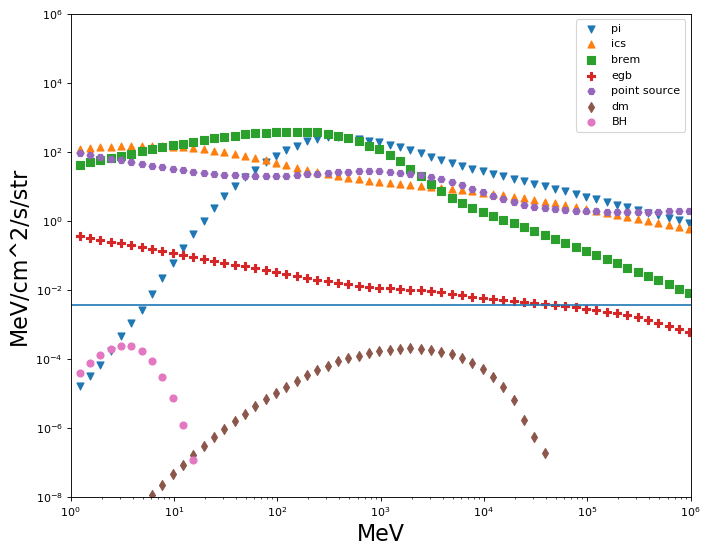

In [19]:
labels = ['pi', 'ics', 'brem', 'egb', 'point source', 'dm', 'BH']
stile = ["v", "^", "s", "P", "H", "d", "o"]

fntsz=20
plt.close()
plt.figure(figsize=(10, 8), dpi=80)

for i in range(0, len(normals)):
    #if ((i == 6) | (i==5)):
        #plt.scatter(energies, normals[i]*.38/0.0957/deltae*energies**2, label = labels[i], marker = stile[i], s = 40)
    #else:
    plt.scatter(energies, normals[i]/deltae*energies**2, label = labels[i], marker = stile[i], s = 40)
    
plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 1e6)
plt.xlim(1e0, 1e6)
plt.axhline(y = 1e3*3.6e-6)
plt.legend()
#plt.show()
plt.savefig('test_evap_norms3.pdf')


In [18]:
'''
deltae_cut = np.copy(deltae[3:])
units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]
fntsz = 10

for i in range(0, len(normals)):
    plt.scatter(cut_energy, normals[i]/units*cut_energy**2, label = str(i))


plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-7, 1e2)
plt.show()
plt.close()
#plt.ylim(1e-8, 3e1)
#plt.legend()
'''


"\ndeltae_cut = np.copy(deltae[3:])\nunits = deltae_cut*exposure_time/196608*acceptances\ncut_energy = energies[3:]\nfntsz = 10\n\nfor i in range(0, len(normals)):\n    plt.scatter(cut_energy, normals[i]/units*cut_energy**2, label = str(i))\n\n\nplt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)\nplt.xlabel('MeV', fontsize = fntsz)\nplt.legend(fontsize = 15)\nplt.yscale('log')\nplt.xscale('log')\nplt.ylim(1e-7, 1e2)\nplt.show()\nplt.close()\n#plt.ylim(1e-8, 3e1)\n#plt.legend()\n"

In [19]:
#code that returns the log-likelihood at a specific point. cube is first parameter, everything else are random parameters
#that are not part of the fitting cube

#cube, pitest, icstest, bremtest, egbtest, pointstest, darkmtest, blackholetest, ktest
def likelihood_poisson_multinest(cube, pitest, icstest, bremtest, egbtest, pointstest, darkmtest, blackholetest, ktest):
    
    a0 = 10**cube[0]
    a1 = 10**cube[1]
    a2 = 10**cube[2]
    a3 = 10**cube[3]
    lamb = a0*pitest+a1*icstest+a2*bremtest+egbtest+a3*pointstest+darkmtest + blackholetest
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

#pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest
def likelihood_poisson_multinest2(cube, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest, blackholetest):
    a0 = cube[0]
    a1 = cube[1]
    a2 = cube[2]
    a3 = cube[3]
    
    lamb = a0 * pitest + a1 * icstest + a2 * bremtest + egbtest + a3 * pointstest + darkmtest + blackholetest

    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return -2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

#finds the log likelihood based on the constants that pymultinest have found. The constants have already
#been moved from logspace to linearspace
#I do this for every energy bin, and come out with one big log likelihood value for some value of sigmav.
#constants, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest, blackholetest
def likelihood_poisson_forsigmav(constants, piflux, icsflux, bremflux, egbflux, pointsflux, ktesthere,
                                 darkmatter, blackholetest):
    #Constants are my consants for pi, ics, brem, and point sources. the constant in front of egb is 1.
    #The 'constant' in front of the dark matter is already incorporated by changing sigmav
    #This is my value of lambda
    lambd = constants[0]*piflux+constants[1]*icsflux+constants[2]*bremflux+egbflux+constants[3]*pointsflux+darkmatter+blackholetest

    
    #my value of k (ktest) is the poisson drawn values from sum of all the templates except dm
    fprob = -scipy.special.gammaln(ktesthere+1)+ktesthere*np.log(lambd)-lambd #log likelihood of poisson
    #scipy.special.gammaln is for the log of a factorial
    return -2*np.nansum(fprob) #the sum of all the log likelihoods for each spatial point. 

##This is the prior function, it is flat in linear space, from a minimum value specified by the first number, 
#to a maximum number specified by the first number + the second number. 
#The variables were called a/b/c/phi0/phi1/norm in this code.
#You need to define a prior for every parameter you send

cube_limits = [(-2, 4), (-2, 4), (-2, 4), (-2, 4)]

def prior(cube, ndim, nparams):
    #cube[0] = (cube[0]*np.abs(np.log10(1.1)-np.log10(.9)) - np.log10(.9)) #from 1e-4 to 1e6 apparently
    cube[0] = (cube[0]*cube_limits[0][1] + cube_limits[0][0])
    cube[1] = (cube[1]*cube_limits[1][1] + cube_limits[1][0])
    cube[2] = (cube[2]*cube_limits[2][1] + cube_limits[2][0])
    cube[3] = (cube[3]*cube_limits[3][1] + cube_limits[3][0])
    return cube

##This is the loglikelihood function for multinest – it sends the cube,
#and then a bunch of different arrays that were used in fitting, but were constant, to the pymultinest code
def loglikelihood_formulti(cube, ndim, nparms):
    return likelihood_poisson_multinest(cube, pitest, icstest, bremtest, egbtest, pointstest, darkmtest, blackholetest, ktest)


In [20]:
def get_dm_array(cross_section = 1.4e-26, dm_mass = 40):
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    templates = []
    temp = []
    deltaomega = 4*np.pi/196608 #i think this should maybe still be total bins in whole image pre-20?
    dm_temp = []
    dm_templates_tot = []
    for index in range(3, len(energies)):
        energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[index]
        bins_in_lin = np.log10(energybin)
        deltae = get_deltaE(index)
    
        highe = (energybin+deltae)/1e3
        lowe = (energybin-deltae)/1e3
        data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_section, massx = dm_mass, for_normals = True)[1] #units of photons cm^-2 str^-1 per sec not per MeV?
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dm_temp.append(np.nansum(data50)/deltae) 
    dm_templates_tot.append(np.asarray(dm_temp)) #photons per s per cm^2 per MeV per str
    return dm_templates_tot




In [21]:
#get all ktests

ktest_array = []
importlib.reload(aaa)

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 1.4e-26
deltae_cut = np.copy(deltae)

egb_counts = get_all_egb(energies, deltae)/deltae_cut
counting = 0


for energyidx in range(0, len(energies)):
    print(energyidx)
    pitest = poisson_dist(2, int(energyidx))
    icstest = poisson_dist(4, int(energyidx))
    bremtest = poisson_dist(0, int(energyidx))
    #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
    egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting])


    #Point Sources
    pointstest = poisson_dist(np.nan, energyidx, points = True) 


    #gotta add egbtest to the ktest

    #ktest = pitest+icstest+bremtest+darkmtest+egbtest+pointstest+darkmtest
    ktest1 = simulated_data(int(energyidx), [pitest, icstest, bremtest, egbtest, pointstest])
    ktest_array.append(ktest1)
    
    counting += 1
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [22]:
import time

#now need to get the values from the folder, and then calculate the loglikelihood with the dark matter
test_crosses_init = np.logspace(np.log10(1e-25), np.log10(1e-29), num = 6)

test_crosses = np.concatenate((test_crosses_init, [0]))
print(test_crosses)
#likelihood_collection = [0 for x in range(len(test_crosses))]
total_likelihood = 0

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 1.4e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae)
    
#probably do for every value of sigmav:
counting_crossec = 0
importlib.reload(dmj)

deltaE = get_deltaE(energyidx)
hdu = readfile(filelist[0])
energy_here = float(hdu[38].data[energyidx][0])
acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2

units = deltae_cut*exposure_time/196608*acceptance_forpoisson


likelihood_collection = []
test_cross_here = 1.4e-26

frac_bh = [1e-3, 1e-2, 1e-1, 1]

frac_bh = [1e-4]

#timing
start = time.time()

#for dark matter, going to choose a cross section, maybe 2.2e-26?
for fbh in frac_bh:
    #test_cross_here = 1e-26
    print('--------------------------')
    print('Frac of DM In Black Holes:')
    test_cross = float("%.5g" % test_cross_here)
    print(fbh)
    print('--------------------------')
    #getting errors and stuff for the dark matter stuff
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    #cross_sec normalized to 2.2e-26
    points = []
    errors = []
    values = []
    fluxes = []
    deltae_cut = np.copy(deltae)


    #EGB getting now, first get all the counts at each energy bin
    egb_counts = get_all_egb(energies, deltae)/deltae_cut #units of counts per cm^2 per sec per str per MeV

    ##These are the names of the parameters we are fitting.
    parameters = ['a0', 'a1', 'a2', 'a3']
    #parameters = ['a0', 'a1', 'a2']
    folder = './pymultinest_chains/f_BH_chains_13yrs/'
    livepoints = 400

    '''Check if directory exists, if not, create it'''
    import os

    # You should change 'test' to your preferred folder.
    MYDIR1 = (folder + "fbh" + str(fbh))
    folder_name = "fbh" + str(fbh)
    CHECK_FOLDER = os.path.isdir(MYDIR1)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR1)
        print("created folder : ", MYDIR1)

    else:
        print(MYDIR1, "folder already exists.")
    
    #getting the constants in front of the poission dist. arrays
    temp_likelihood = 0
    counting = 0
    for energyidx in range(0, len(energies)):
        counting = energyidx
        #counting = 18-3
        # You should change 'test' to your preferred folder.
        MYDIR = (MYDIR1 + "/chain" + str(energyidx))
        CHECK_FOLDER = os.path.isdir(MYDIR)

        # If folder doesn't exist, then create it.
        if not CHECK_FOLDER:
            os.makedirs(MYDIR)
            print("created folder : ", MYDIR)

        else:
            print(MYDIR, "folder already exists.")
        print(energyidx, energies[energyidx])
        
        #photons per pixel
        pitest = poisson_dist(2, int(energyidx), cross_section = test_cross)
        icstest = poisson_dist(4, int(energyidx), cross_section = test_cross)
        bremtest = poisson_dist(0, int(energyidx), cross_section = test_cross)
        
        #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
        egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting], cross_section = test_cross)
        
        #Dark matter
        importlib.reload(dmj) 
        darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = test_cross, analyze_data = False)

        darkmtest[np.isnan(darkmtest)] = 0
        
        #Black Holes
        blackholetest = poisson_dist(np.nan, int(energyidx), cross_section = test_cross, dm_bh = True, evapbh = True, blackholem = 2e16)

        blackholetest[np.isnan(blackholetest)] = 0
        
        
        #Point Sources
        pointstest = poisson_dist(np.nan, energyidx, points = True, cross_section = test_cross) 

        #gotta add egbtest to the ktest

        #ktest = pitest+icstest+bremtest+darkmtest+egbtest+pointstest+darkmtest
        ktest = ktest_array[counting]
        
        print(np.sum(ktest))
        print(np.sum(pitest+icstest+bremtest+egbtest+pointstest+darkmtest+blackholetest))

        
        
        finals = pymultinest.run(loglikelihood_formulti, prior, int(len(parameters)), outputfiles_basename=MYDIR+"/"+ str(energyidx), n_live_points=livepoints, resume=True, verbose=True)
        json.dump(parameters, open(MYDIR+'/' + str(energyidx) + 'params' +'.json', 'w'))
        counting += 1
        
        #now need to find the likelihood for this best fit value
        
        #create the .data file
        !python3 ./pymultinest_chains/multinest_marginals.py ./{MYDIR1}/chain{energyidx}/{energyidx}
        #Open the file
        path_to_this_file = MYDIR + '/' + str(energyidx) + 'stats.json'
        f = open(path_to_this_file)
        filehere = json.load(f)
        print(path_to_this_file)
        constants = []
        testpoints0 = (10**(filehere['marginals'][0]['median'])) #pitest
        testpoints1 = (10**(filehere['marginals'][1]['median'])) #icstest
        testpoints2 = (10**(filehere['marginals'][2]['median'])) #bremtest
        testpoints3 = (10**(filehere['marginals'][3]['median'])) #pointsources
        print('---------------')
        constants=[testpoints0, testpoints1, testpoints2, testpoints3]
        print(constants)
        print(likelihood_poisson_multinest2([testpoints0, testpoints1, testpoints2, testpoints3], pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest, blackholetest))
        print('---------------')
        lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+egbtest+constants[3]*pointstest+darkmtest+blackholetest
        print(lamb)
        
        likehere = likelihood_poisson_forsigmav(constants, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest, blackholetest)
        temp_likelihood += likehere
        #temp_likelihood += -2*filehere["modes"][0]["strictly local log-evidence"]
        print(likehere)
    print('------------')
    likelihood_collection.append(temp_likelihood)
    counting_crossec +=1

print('----------')


#break

print('------------------')

end = time.time()
print('total time:')
print(end - start)

[1.00000000e-25 1.58489319e-26 2.51188643e-27 3.98107171e-28
 6.30957344e-29 1.00000000e-29 0.00000000e+00]
--------------------------
Frac of DM In Black Holes:
0.0001
--------------------------
created folder :  ./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001
created folder :  ./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain0
0 49.99999999999999
sigmav: 2.2e-26
5872285.0
5871071.945301408
model "././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain0/0"
  analysing data from ././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain0/0.txt
  marginal likelihood:
    ln Z = -57661.3 +- 0.1
  parameters:
    a0             -1.08 +- 0.66
    a1             0.0019 +- 0.0028
    a2             0.047 +- 0.012
    a3             -0.0071 +- 0.0051
creating marginal plot ...
./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain0/0stats.json
---------------
[0.08261410192560333, 1.0044919023489935, 1.1137039146993322, 0.9836820775572847]
57645.31437556879
---------------
[616.25316534 

./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain9/9stats.json
---------------
[0.8134732166442076, 0.9754902896610397, 1.198591596196963, 1.008036804814236]
53009.975282412845
---------------
[266.95290903 263.68959534 262.238112   ... 162.14207942 171.17176587
 180.80119241]
53009.975282412845
created folder :  ./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain10
10 687.4738295408508
sigmav: 2.2e-26
2777598.0
2799360.5296791084
model "././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain10/10"
  analysing data from ././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain10/10.txt
  marginal likelihood:
    ln Z = -51797.2 +- 0.1
  parameters:
    a0             -0.046 +- 0.013
    a1             -0.0153 +- 0.0019
    a2             0.051 +- 0.012
    a3             -0.0014 +- 0.0014
creating marginal plot ...
./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain10/10stats.json
---------------
[0.8993615654438478, 0.9653929574536643, 1.1248724109709578, 0.9968106701099645

./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain19/19stats.json
---------------
[0.8883902611579562, 0.8178225376240624, 1.4631769857392098, 0.9876047524687787]
32687.484404659855
---------------
[8.75318476 9.55569086 8.4796314  ... 5.38046673 6.52967669 6.32619021]
32687.484404659855
created folder :  ./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain20
20 9452.405326071254
sigmav: 2.2e-26
81569.0
85041.6300608399
model "././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain20/20"
  analysing data from ././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain20/20.txt
  marginal likelihood:
    ln Z = -30230.0 +- 0.7
  parameters:
    a0             -0.014 +- 0.020
    a1             -0.0911 +- 0.0093
    a2             0.128 +- 0.054
    a3             -0.0020 +- 0.0026
creating marginal plot ...
./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain20/20stats.json
---------------
[0.9688432421072606, 0.8106878074080868, 1.3436235707751134, 0.9954228755472899]
30210.24482

./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain29/29stats.json
---------------
[0.04642035952079595, 0.012283585184435526, 0.08096838438249475, 2.494825593536724]
6310.277778754495
---------------
[ 0.13071109  0.05595995  0.14137628 ...  0.20045693 -0.10286397
  0.226683  ]
6310.277778754495
created folder :  ./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain30
30 129965.62575773097
sigmav: 2.2e-26
1250.0
1210.537661348191
model "././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain30/30"
  analysing data from ././pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain30/30.txt
  marginal likelihood:
    ln Z = -4597.4 +- 0.2
  parameters:
    a0             -1.924 +- 0.056
    a1             -1.963 +- 0.036
    a2             -1.65 +- 0.26
    a3             0.3298 +- 0.0010
creating marginal plot ...
./pymultinest_chains/f_BH_chains_13yrs/fbh0.0001/chain30/30stats.json
---------------
[0.011916231738113198, 0.010894332302743172, 0.02236723575045725, 2.1370171012506676]
45

In [23]:
#collect the data from the saved files

'''
Collect the data from the files created
'''
def reverse_norm(arrhere, norm, deltae, acceptance_here, error = False):
    if error:
        normhere = np.copy(norm)
        deltaehere = np.copy(deltae)
        arr = np.array(arrhere).T
        adjusted_arr0 = np.array(arr[0])*np.array(normhere)
        adjusted_arr1 = np.array(arr[1])*np.array(normhere)
        counts0 = np.array((adjusted_arr0*196608)).T #counts
        counts1 = np.array((adjusted_arr1*196608)).T #counts
        per0 = counts0/(np.array(exposure_time*acceptance_here)) #counts divided by exposure time divided by acceptance rate
        per1 = counts1/(np.array(exposure_time*acceptance_here)) #counts divided by exposure time divided by acceptance rate
        fin = np.array([np.array(per0/deltaehere), np.array(per1/deltaehere)])
    else:
        adjusted_arr = np.array(arrhere)*np.array(norm)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*acceptance_here) #counts divided by exposure time divided by acceptance rate

        fin = per/deltae
    return np.array(fin) #counts per MeV per sec per str per cm^2

def get_errors(middle, index, filehere, val):
    sigma1_down = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][0]))
    sigma1_up = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][1]))
    sigma_gap = 2*np.abs(10**(filehere['marginals'][val]['1sigma'][0])-middle)
    
    
    dist = np.abs(10**(cube_limits[val][0])-middle)
    
    if sigma_gap > dist:
        return [sigma1_down, sigma1_up], True
    else:
        return [sigma1_down, sigma1_up], False

deltae_cut = np.copy(deltae)
points0 = []
points1 = []
points2 = []
points3 = []

errors0 = []
errors1 = []
errors2 = []
errors3 = []

errors0_twosig = []
errors1_twosig = []
errors2_twosig = []
errors3_twosig = []

testerr3 = []

arrow = []

hdu = readfile(filelist[0])
energy_here = np.concatenate(hdu[38].data, axis = 0)
acceptance_here = acceptance_interp(energy_here)

f = []
folder = './pymultinest_chains/f_BH_chains_13yrs/'
test_crosses = [1.4e-26]
mypath = folder
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]
print(chains_list)


['fbh0.0001']


In [28]:
print(folder)

./pymultinest_chains/f_BH_chains/


In [24]:
# i think i need to go in order of the energies, not just the list of filenames
print(mypath)
for fbh in frac_bh:
    for number in range(0, len(energies)):
        file = 'chain' + str(number)
        number = re.sub('\D', '', str(file))
        path_to_this_file = mypath + "fbh" + str(fbh) + "/" + file + '/' + str(number) + 'stats.json'
        #print(path_to_this_file)
        f = open(path_to_this_file)
        filehere = json.load(f)

        testpoints0 = (10**(filehere['marginals'][0]['median']))
        testpoints1 = (10**(filehere['marginals'][1]['median']))
        testpoints2 = (10**(filehere['marginals'][2]['median']))
        testpoints3 = (10**(filehere['marginals'][3]['median']))
        #testpoints4 = (10**(filehere['marginals'][4]['median']))
        #testpoints5 = (10**(filehere['marginals'][5]['median']))

        errors_pi, errors0_twosig = get_errors(testpoints0, 0, filehere, 0)
        errors_ics, errors1_twosig = get_errors(testpoints1, 0, filehere, 1)
        errors_brem, errors2_twosig = get_errors(testpoints2, 0, filehere, 2)
        #errors_dm, errors3_twosig = get_errors(testpoints3, 0, filehere, 3)
        #errors_egb, errors4_twosig = get_errors(testpoints4, 0, filehere, 4)
        errors_sources, errors3_twosig = get_errors(testpoints3, 0, filehere, 3)

        arrow.append([errors0_twosig, errors1_twosig, errors2_twosig, errors3_twosig])

        order = 100
    
        if errors0_twosig == True:
            points0.append(10**(filehere['marginals'][0]['2sigma'][1]))
            sig1 = 10**(filehere['marginals'][0]['2sigma'][1])
            errors0.append([np.abs(sig1/order-sig1), 0])
        else:
            points0.append(10**(filehere['marginals'][0]['median']))
            errors0.append(errors_pi)
        if errors1_twosig == True:
            points1.append(10**(filehere['marginals'][1]['2sigma'][1]))
            sig1 = 10**(filehere['marginals'][1]['2sigma'][1])
            errors1.append([np.abs(sig1/order-sig1), 0])
        else:
            points1.append(10**(filehere['marginals'][1]['median']))
            errors1.append(errors_ics)
        if errors2_twosig == True:
            points2.append(10**(filehere['marginals'][2]['2sigma'][1]))
            sig1 = 10**(filehere['marginals'][2]['2sigma'][1])
            errors2.append([np.abs(sig1/order-sig1), 0])
        else:
            points2.append(10**(filehere['marginals'][2]['median']))
            errors2.append(errors_brem)
        if errors3_twosig == True:
            points3.append(10**(filehere['marginals'][3]['2sigma'][1]))
            sig1 = 10**(filehere['marginals'][3]['2sigma'][1])
            errors3.append([np.abs(sig1/order-sig1), 0])
        else:
            points3.append(10**(filehere['marginals'][3]['median']))
            errors3.append(errors_sources)
            testerr3.append(10**(filehere['marginals'][3]['median']))
        '''
        if errors4_twosig == True:
            points4.append(10**(filehere['marginals'][4]['2sigma'][1]))
            sig1 = 10**(filehere['marginals'][4]['2sigma'][1])
            errors4.append([np.abs(sig1/order-sig1), 0])
        else:
            points4.append(10**(filehere['marginals'][4]['median']))
            errors4.append(errors_egb)
        if errors5_twosig == True:
            points5.append(10**(filehere['marginals'][5]['2sigma'][1]))
            sig1 = 10**(filehere['marginals'][5]['2sigma'][1])
            errors5.append([np.abs(sig1/order-sig1), 0])
        else:
            points5.append(10**(filehere['marginals'][5]['median']))
            errors5.append(errors_egb)
        '''


piflux = reverse_norm(points0, normals[0], deltae_cut, acceptance_here)
piflux_err = reverse_norm(errors0, normals[0], deltae_cut, acceptance_here, error = True).T
icsflux = reverse_norm(points1, normals[1], deltae_cut, acceptance_here)
icsflux_err = reverse_norm(errors1, normals[1], deltae_cut, acceptance_here, error = True).T
bremflux = reverse_norm(points2, normals[2], deltae_cut, acceptance_here)
bremflux_err = reverse_norm(errors2, normals[2], deltae_cut, acceptance_here, error = True).T
#dmflux = reverse_norm(points3, normals[3][0], deltae_cut)
#dmfluxtest = reverse_norm(testerr3, normals[3][0], deltae_cut)
#dmflux_err = reverse_norm(errors3, normals[3][0], deltae_cut, error = True).T
#egbflux = reverse_norm(points3, normals[3], deltae_cut, acceptance_here)
#egbflux_err = reverse_norm(errors3, normals[3], deltae_cut, acceptance_here, error = True).T
pointsflux = reverse_norm(points3, normals[4], deltae_cut, acceptance_here)
pointsflux_err = reverse_norm(errors3, normals[4], deltae_cut, acceptance_here, error = True).T
arrow = np.array(arrow).T

./pymultinest_chains/f_BH_chains_13yrs/


In [ ]:
print(cut_energy[0:9])

In [25]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[0])), True)

units = deltae_cut*exposure_time*acceptance_here/196608
cut_energy = np.copy(energies)

#Pi0
for i in range(0, len(arrow[0])):
    if arrow[0][i] == True:
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[i][0]*cut_energy[i]**2, piflux_err[i][1]*cut_energy[i]**2)]).T, uplims = arrow[0][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], piflux[i]*cut_energy[i]**2, color = 'greenyellow', marker = 'X', s = sizeofdot)
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[i][0]*cut_energy[i]**2, piflux_err[i][1]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
plt.scatter(0, 0, label = r'$\pi^0$', color = 'greenyellow', marker = 'x', s = sizeofdot)

#ICS
for i in range(0, len(arrow[1])):
    if arrow[1][i] == True:
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[i][0]*cut_energy[i]**2, icsflux_err[i][1]*cut_energy[i]**2)]).T, uplims = arrow[1][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], icsflux[i]*cut_energy[i]**2, color = 'skyblue', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[i][0]*cut_energy[i]**2, icsflux_err[i][1]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
plt.scatter(0, 0, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)

#Bremm
for i in range(0, len(arrow[2])):
    if arrow[2][i] == True:
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[i][0]*cut_energy[i]**2, bremflux_err[i][1]*cut_energy[i]**2)]).T, uplims = arrow[2][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], bremflux[i]*cut_energy[i]**2, color = 'peachpuff', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[i][0]*cut_energy[i]**2, bremflux_err[i][1]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'darkorange')
plt.scatter(0, 0, label = 'Bremm', color = 'peachpuff', marker = '*', s = sizeofdot)

#Point sources
for i in range(0, len(arrow[3])):
    if arrow[3][i] == True:
        plt.errorbar(cut_energy[i], pointsflux[i]*cut_energy[i]**2, yerr = np.array([(pointsflux_err[i][0]*cut_energy[i]**2, pointsflux_err[i][1]*cut_energy[i]**2)]).T, uplims = arrow[3][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], pointsflux[i]*cut_energy[i]**2, color = 'orchid', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], pointsflux[i]*cut_energy[i]**2, yerr = np.array([(pointsflux_err[i][0]*cut_energy[i]**2, pointsflux_err[i][1]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
plt.scatter(0, 0, label = 'Point Sources', color = 'orchid', marker = '>', s = sizeofdot)


#EGB
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'darkgoldenrod')
plt.scatter(0, 0, label = 'EGB', color = 'gold', marker = '*', s = sizeofdot)


#Dark Matter
plt.scatter(cut_energy, normals[5][0]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(0, 0, label = 'DM', color = 'maroon', marker = '>', s = sizeofdot)


#Black Holes
plt.scatter(cut_energy, normals[6][0]/units*cut_energy**2, color = 'lightblue', label = 'Black Holes')
plt.scatter(0, 0, label = 'BHs', color = 'aqua', marker = '*', s = sizeofdot)

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 3e2)
plt.legend()

plt.savefig('testing1.pdf')


In [ ]:

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20

plt.scatter(test_crosses[0:10], np.abs(np.array(likelihood_collection[0:10])-likelihood_collection[-1]), s = 50)
plt.yscale('log')
plt.xscale('log')
plt.xlim(np.nanmin(test_crosses)*.95, np.nanmax(test_crosses)*1.5)
plt.xlabel(r'$\sigma$v', fontsize=fntsz)
plt.ylabel('2lnL', fontsize=fntsz)
#plt.ylim(0, 10)
plt.xlim(1e-30, 1e-25)
plt.ylim(1e-1, 1e6)
plt.hlines(4, 1e-30, 1e-23)
plt.show()
#plt.savefig('loglikelihood_zoomtest1.pdf')

#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))


In [ ]:
true_values = ktest_array[12]



energyidx = 12+3
counting = 12

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]

egb_counts = get_all_egb(energies, deltae)/deltae_cut

#photons per pixel
pitest = poisson_dist(2, int(energyidx), cross_section = test_cross)
icstest = poisson_dist(4, int(energyidx), cross_section = test_cross)
bremtest = poisson_dist(0, int(energyidx), cross_section = test_cross)


#EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting], cross_section = test_cross)

importlib.reload(dmj) 
darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = test_cross, analyze_data = False)

darkmtest[np.isnan(darkmtest)] = 0

#Point Sources
pointstest = poisson_dist(np.nan, energyidx, points = True, cross_section = test_cross) 

vals_w_dm = np.copy(lamb)

print(test_cross)


In [ ]:
energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[energyidx]
bins_in_lin = np.log10(energybin)
deltae_here = get_deltaE(energyidx)
    
highe = (energybin+deltae_here)/1e3
lowe = (energybin-deltae_here)/1e3
    
hdu = readfile(filelist[0])
numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
NSIDE = int(hdu[0].header['NSIDE'])
    
degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    
    
#need to make sure the initsum is *only within the inner 20 degrees, same for finsum
data50 = dmj.get_dNdE(highe, lowe, sigmav = test_cross, analyze_data = False, massx = 100)[1] #photons per cm^2 per sec per str per MeV
    
#get_where_within_20deg
numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
NSIDE = int(hdu[0].header['NSIDE'])
vec = hp.ang2vec(np.pi/2, 0)
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)

ipix_disc_big = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(360), inclusive = False)

data50[ipix_disc_big] = np.nan

data501 = np.copy(data50)
data502 = np.copy(data50)

data501[ipix_disc] = true_values
data502[ipix_disc] = vals_w_dm


    

In [ ]:
hp.mollview((data501), coord = 'G')

hp.mollview((data502), coord = 'G')

hp.mollview((np.abs(data501-data502)), coord = 'G')

In [ ]:
ipix_disc1 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(1), inclusive = False)
print(ipix_disc1)
print(data50[99071])
print(np.where(ipix_disc == 99071))

print(pitest[3053])
print(bremtest[3053])
print(egbtest[3053])
print(pointstest[3053])
print(icstest[3053])
print(darkmtest[3053])





In [ ]:
print(data501)
print(data502)

plt.hist(np.abs(data501-data502), bins = 20)


In [ ]:
test_crosses_init = np.logspace(np.log10(1e-22), np.log10(1e-27), num = 20)
test_crosses = np.concatenate((test_crosses_init, [0]))
test_cross = test_crosses_init[0]
counting = 0
for energyidx in range(3, len(energies)):        
    #photons per pixel
    pitest = poisson_dist(2, int(energyidx))
    icstest = poisson_dist(4, int(energyidx))
    bremtest = poisson_dist(0, int(energyidx))


    #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
    egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting])

    importlib.reload(dmj) 
    darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = test_cross, analyze_data = False)

    darkmtest[np.isnan(darkmtest)] = 0

    #Point Sources
    pointstest = poisson_dist(np.nan, energyidx, points = True) 


    #gotta add egbtest to the ktest

    #ktest = pitest+icstest+bremtest+darkmtest+egbtest+pointstest+darkmtest
    ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest, egbtest, pointstest, darkmtest])
    tot = pitest+icstest+bremtest+egbtest+pointstest+darkmtest
    
    plt.hist(ktest, color = 'red')
    plt.hist(tot, color = 'blue')
    counting += 1
    sdfasd
    

In [ ]:
print(np.array(likelihood_collection[0:10]-likelihood_collection[-1]))
print(likelihood_collection)

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20

plt.scatter(test_crosses[0:10], np.abs(np.array(likelihood_collection[0:10]-likelihood_collection[-1])), s = 50)
#plt.yscale('log')
plt.xscale('log')
plt.xlim(np.nanmin(test_crosses)*.95, np.nanmax(test_crosses)*1.5)
plt.xlabel(r'$\sigma$v', fontsize=fntsz)
plt.ylabel('2lnL', fontsize=fntsz)
#plt.ylim(0, 10)
plt.xlim(1e-27, 1e-20)
plt.ylim(0, 1e2)
#plt.savefig('loglikelihood_zoom.pdf')

#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))


In [ ]:
## Trying to get the log likelihoods another way
import os

test_crosses_init = np.logspace(np.log10(1e-22), np.log10(1e-27), num = 10)
test_crosses = np.concatenate((test_crosses_init, [0]))

likelihoods_test2 = []

for test_cross in test_crosses:
    # You should change 'test' to your preferred folder.
    MYDIR1 = (folder + "cross_sec" + str(test_cross))
    folder_name = "cross_sec" + str(test_cross)
    CHECK_FOLDER = os.path.isdir(MYDIR1)
    templike = 0
    for energyidx in range(3, len(energies)):
        MYDIR = (MYDIR1 + "/chain" + str(energyidx))
        path_to_this_file = MYDIR + '/' + str(energyidx) + 'stats.json'
        f = open(path_to_this_file)
        filehere = json.load(f)
        likeli = -filehere['modes'][0]['strictly local log-evidence']
        templike += likeli
    likelihoods_test2.append(templike)


In [ ]:
print(likelihoods_test2[0:10])
print(likelihoods_test2[-1])
print(np.array(likelihoods_test2[0:10])-likelihoods_test2[-1])


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20

plt.scatter(test_crosses[0:10], np.array(np.array(likelihoods_test2[0:10])-float(likelihoods_test2[-1])), s = 50)
plt.scatter(test_crosses[0:10], np.array(np.array(likelihood_collection[0:10])-float(likelihood_collection[-1])), s = 50, color = 'red')

#plt.yscale('log')
plt.xscale('log')
plt.xlim(np.nanmin(test_crosses)*.95, np.nanmax(test_crosses)*1.5)
plt.xlabel(r'$\sigma$v', fontsize=fntsz)
plt.ylabel('2lnL', fontsize=fntsz)
#plt.ylim(0, 10)

plt.savefig('loglikelihood1.pdf')
plt.xlim(1e-27, 1e-22)
plt.ylim(0, 10)
#plt.ylim(1e-1, 1e3)
#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))
plt.savefig('weird_loglikelihood.pdf')

In [ ]:
#find best fit

#now find best fit for DM

def likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux):
    a0 = 10**cube[0]
    lamb = piflux+icsflux+bremflux+egbflux+sourcesflux+a0*dmflux
    fprob = -scipy.special.gammaln(kflux+1)+kflux*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

def prior_bestfit(cube, ndim, nparams):
    #cube[0] = (cube[0]*np.abs(np.log10(1.1)-np.log10(.9)) - np.log10(.9)) #from 1e-4 to 1e6 apparently
    cube[0] = (cube[0]*2 -1)
    return cube

def loglikelihood_fordmbestfit(cube, ndim, nparms):
    return likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux)

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])


##These are the names of the parameters we are fitting.
parameters = ['a0']
folder = './pymultinest_chains/'
livepoints = 200

'''Check if directory exists, if not, create it'''
import os

# You should change 'test' to your preferred folder.
MYDIR1 = (folder + "bestfit_dm")
CHECK_FOLDER = os.path.isdir(MYDIR1)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR1)
    print("created folder : ", MYDIR1)

else:
    print(MYDIR1, "folder already exists.")
dmflux = (get_dm_array(cross_section = 2.2e-26, dm_mass = 100)*cut_energy**2)[0]
print('got DM flux.')
kflux = piflux+icsflux+bremflux+egbflux+sourcesflux

finals = pymultinest.run(loglikelihood_fordmbestfit, prior_bestfit, int(len(parameters)), outputfiles_basename=MYDIR1+"/bestfitDM", n_live_points=livepoints, resume=True, verbose=True)

json.dump(parameters, open(MYDIR1+'/' + 'params' +'.json', 'w'))


In [ ]:
#now need to get the minimal sigmav
mypath = './pymultinest_chains/bestfit_dm/'

!python3 ./pymultinest_chains/multinest_marginals.py ./pymultinest_chains/bestfit_dm/bestfitDM
number = re.sub('\D', '', str(file))
path_to_this_file = mypath + '/' + 'bestfitDM' + 'stats.json'
f = open(path_to_this_file)
filehere = json.load(f)
print(path_to_this_file)
bestfit_sigmav = (10**(filehere['marginals'][0]['median']))

print(bestfit_sigmav*2.2e-26)

ktesthere = piflux+icsflux+bremflux+egbflux+sourcesflux
darkmatter_min = (get_dm_array(cross_section = bestfit_sigmav*2.2e-26, dm_mass = 100)*cut_energy**2)[0]
min_loglikelihood = likelihood_poisson_forsigmav(piflux, icsflux, bremflux, egbflux, sourcesflux, ktesthere, darkmatter_min)


In [ ]:
cut_energy = energies[3:]
darkmatter = get_dm_array(cross_section = 1e-23, dm_mass = 100)*cut_energy**2


In [ ]:
print(np.nanmax(darkmatter[0]))
print(darkmatter[0][14])

In [ ]:
print(len(ktest_array))
print(len(cut_energy))

In [ ]:

plt.scatter(cut_energy, egbflux, color = 'red')
plt.scatter(cut_energy, darkmatter, color = 'orange')
plt.scatter(cut_energy[14], darkmatter[0][14], color = 'black', s = 50)
plt.scatter(cut_energy, piflux, color = 'yellow')
plt.scatter(cut_energy, icsflux, color = 'green')
plt.scatter(cut_energy, bremflux, color = 'blue')
plt.scatter(cut_energy, sourcesflux, color = 'purple')
plt.scatter(cut_energy[14], darkmatter[0][14], color = 'black', s = 100)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5, 1e2)

In [ ]:
#Need to find best fit to dark matter
#basically just take our best fit values from the 5 templates, and fit them with the dm template
'''
Collect the data from the files created
'''

def reverse_norm(arr, norm, deltae, accept, error = False):
    
    if error:
        normhere = norm.reshape(35, 1)
        deltaehere = deltae.reshape(35, 1)
        adjusted_arr = np.array(arr)*np.array(normhere)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltaehere
    else:
        adjusted_arr = np.array(arr)*np.array(norm)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time**accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltae
    return fin #counts per MeV per sec per str per cm^2

        
points0 = []
points1 = []
points2 = []
points3 = []
points4 = []
points5 = []

arrow = []

f = []
mypath = './pymultinest_chains/6templates_13yrs/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

for number in range(3, len(energies)):
    file = 'chain' + str(number)
    number = re.sub('\D', '', str(file))
    path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
    f = open(path_to_this_file)
    filehere = json.load(f)
    print(path_to_this_file)

    
    testpoints0 = (10**(filehere['marginals'][0]['median']))
    testpoints1 = (10**(filehere['marginals'][1]['median']))
    testpoints2 = (10**(filehere['marginals'][2]['median']))
    testpoints3 = (10**(filehere['marginals'][3]['median']))
    testpoints4 = (10**(filehere['marginals'][4]['median']))
    
    points0.append(testpoints0)
    points1.append(testpoints1)
    points2.append(testpoints2)
    points3.append(testpoints3)
    points4.append(testpoints4)

cut_energy = energies[3:]


acceptances = []
for energyidxhere in range(0, len(cut_energy))
    energyidx = energyidxhere+3
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson)

piflux = reverse_norm(points0, normals[0], deltae_cut, acceptances)*cut_energy**2
icsflux = reverse_norm(points1, normals[1], deltae_cut, acceptances)*cut_energy**2
bremflux = reverse_norm(points2, normals[2], deltae_cut, acceptances)*cut_energy**2
egbflux = reverse_norm(points3, normals[3], deltae_cut, acceptances)*cut_energy**2
sourcesflux = reverse_norm(points4, normals[4], deltae_cut, acceptances)*cut_energy**2


In [ ]:
print(dmflux)

In [ ]:
#now find best fit for DM

def likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux):
    a0 = 10**cube[0]
    lamb = piflux+icsflux+bremflux+egbflux+sourcesflux+a0*dmflux
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

def prior_bestfit(cube, ndim, nparams):
    #cube[0] = (cube[0]*np.abs(np.log10(1.1)-np.log10(.9)) - np.log10(.9)) #from 1e-4 to 1e6 apparently
    cube[0] = (cube[0]*2 -1)
    return cube

def loglikelihood_fordmbestfit(cube, ndim, nparms):
    return likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux)

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])


##These are the names of the parameters we are fitting.
parameters = ['a0']
folder = './pymultinest_chains/'
livepoints = 200

'''Check if directory exists, if not, create it'''
import os

# You should change 'test' to your preferred folder.
MYDIR1 = (folder + "bestfit_dm")
CHECK_FOLDER = os.path.isdir(MYDIR1)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR1)
    print("created folder : ", MYDIR1)

else:
    print(MYDIR1, "folder already exists.")
    
kflux = piflux+icsflux+bremflux+egbflux+sourcesflux
finals = pymultinest.run(loglikelihood_fordmbestfit, prior, int(len(parameters)), outputfiles_basename=MYDIR+"/"+ str(energyidx), n_live_points=livepoints, resume=True, verbose=True)

#now need to get the minimal sigmav
mypath = './pymultinest_chains/bestfit_dm/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

file = 'chain' + str(number)
number = re.sub('\D', '', str(file))
path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
f = open(path_to_this_file)
filehere = json.load(f)
print(path_to_this_file)
bestfit_sigmav = (10**(filehere['marginals'][0]['median']))

print(bestfit_sigmav)


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(test_crosses, likelihood_collection)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-24, 1e-28)
#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))

In [ ]:
for idx in range(3, len(energies)):
    !python3 ./pymultinest_chains/multinest_marginals.py ./pymultinest_chains/6templates_13yrs/chain{idx}/{idx}

In [ ]:
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])

In [ ]:
'''
Collect the data from the files created
'''

def reverse_norm(arr, norm, deltae, accept, error = False):
    if error:
        normhere = norm.reshape(35, 1)
        deltaehere = deltae.reshape(35, 1)
        adjusted_arr = np.array(arr)*np.array(normhere)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltaehere
    else:
        adjusted_arr = np.array(arr)*np.array(norm)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltae
    return fin #counts per MeV per sec per str per cm^2

def get_errors(middle, index, filehere, val):
    sigma1_down = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][0]))
    sigma1_up = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][1]))
    sigma_gap = 2*np.abs(10**(filehere['marginals'][val]['1sigma'][0])-middle)
    
    
    dist = np.abs(10**(cube_limits[val][0])-middle)
    
    if sigma_gap > dist:
        return [sigma1_down, sigma1_up], True
    else:
        return [sigma1_down, sigma1_up], False
        
points0 = []
points1 = []
points2 = []
points3 = []
points4 = []
points5 = []

errors0 = []
errors1 = []
errors2 = []
errors3 = []
errors4 = []
errors5 = []

errors0_twosig = []
errors1_twosig = []
errors2_twosig = []
errors3_twosig = []
errors4_twosig = []
errors5_twosig = []

testerr3 = []

arrow = []

f = []
mypath = './pymultinest_chains/6templates_13yrs/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

#for i in range(3, len(energies)):
    #x = (np.loadtxt(MYDIR + '/params' + str(i) + 'stats.dat', skiprows = 4, dtype = 'float', max_rows = 5).T)

# i think i need to go in order of the energies, not just the list of filenames
for number in range(3, len(energies)):
    file = 'chain' + str(number)
    number = re.sub('\D', '', str(file))
    path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
    f = open(path_to_this_file)
    filehere = json.load(f)
    print(path_to_this_file)
    '''
    points0.append((filehere['marginals'][0]['median']))
    points1.append((filehere['marginals'][1]['median']))
    points2.append((filehere['marginals'][2]['median']))
    points3.append((filehere['marginals'][3]['median']))
    points4.append((filehere['marginals'][4]['median']))
    errors0.append((filehere['marginals'][0]['sigma']))
    errors1.append((filehere['marginals'][1]['sigma']))
    errors2.append((filehere['marginals'][2]['sigma']))
    errors3.append((filehere['marginals'][3]['sigma']))
    errors4.append((filehere['marginals'][4]['sigma']))
    '''
    
    testpoints0 = (10**(filehere['marginals'][0]['median']))
    testpoints1 = (10**(filehere['marginals'][1]['median']))
    testpoints2 = (10**(filehere['marginals'][2]['median']))
    testpoints3 = (10**(filehere['marginals'][3]['median']))
    testpoints4 = (10**(filehere['marginals'][4]['median']))
    testpoints5 = (10**(filehere['marginals'][5]['median']))

    errors_pi, errors0_twosig = get_errors(testpoints0, 0, filehere, 0)
    errors_ics, errors1_twosig = get_errors(testpoints1, 0, filehere, 1)
    errors_brem, errors2_twosig = get_errors(testpoints2, 0, filehere, 2)
    errors_dm, errors3_twosig = get_errors(testpoints3, 0, filehere, 3)
    errors_egb, errors4_twosig = get_errors(testpoints4, 0, filehere, 4)
    errors_sources, errors5_twosig = get_errors(testpoints5, 0, filehere, 4)
    

    
    arrow.append([errors0_twosig, errors1_twosig, errors2_twosig, errors3_twosig, errors4_twosig, errors5_twosig])
    
    #want line to be one order of magnitude below the top part of the line
    order = 100
    
    if errors0_twosig == True:
        points0.append(10**(filehere['marginals'][0]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][0]['2sigma'][1])
        errors0.append([np.abs(sig1/order-sig1), 0])
    else:
        points0.append(10**(filehere['marginals'][0]['median']))
        errors0.append(errors_pi)
    if errors1_twosig == True:
        points1.append(10**(filehere['marginals'][1]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][1]['2sigma'][1])
        errors1.append([np.abs(sig1/order-sig1), 0])
    else:
        points1.append(10**(filehere['marginals'][1]['median']))
        errors1.append(errors_ics)
    if errors2_twosig == True:
        points2.append(10**(filehere['marginals'][2]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][2]['2sigma'][1])
        errors2.append([np.abs(sig1/order-sig1), 0])
    else:
        points2.append(10**(filehere['marginals'][2]['median']))
        errors2.append(errors_brem)
    if errors3_twosig == True:
        points3.append(10**(filehere['marginals'][3]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][3]['2sigma'][1])
        errors3.append([np.abs(sig1/order-sig1), 0])
    else:
        points3.append(10**(filehere['marginals'][3]['median']))
        errors3.append(errors_dm)
    testerr3.append(10**(filehere['marginals'][3]['median']))
    if errors4_twosig == True:
        points4.append(10**(filehere['marginals'][4]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][4]['2sigma'][1])
        errors4.append([np.abs(sig1/order-sig1), 0])
    else:
        points4.append(10**(filehere['marginals'][4]['median']))
        errors4.append(errors_egb)
    if errors5_twosig == True:
        points5.append(10**(filehere['marginals'][5]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][5]['2sigma'][1])
        errors5.append([np.abs(sig1/order-sig1), 0])
    else:
        points5.append(10**(filehere['marginals'][5]['median']))
        errors5.append(errors_egb)
    
    #cube_limits = [(-2, 4), (-2, 4), (-3, 6), (-6, 12), (-3, 6)]
    #print(int(number))
    
acceptances = []
for energyidxhere in range(0, len(cut_energy))
    energyidx = energyidxhere+3
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson) 
    
piflux = reverse_norm(points0, normals[0], deltae_cut, acceptances)
piflux_err = reverse_norm(errors0, normals[0], deltae_cut, acceptances, error = True).T
icsflux = reverse_norm(points1, normals[1], deltae_cut, acceptances, )
icsflux_err = reverse_norm(errors1, normals[1], deltae_cut, acceptances,  error = True).T
bremflux = reverse_norm(points2, normals[2], deltae_cut, acceptances)
bremflux_err = reverse_norm(errors2, normals[2], deltae_cut, acceptances, error = True).T
dmflux = reverse_norm(points3, normals[3][0], deltae_cut, acceptances)
dmfluxtest = reverse_norm(testerr3, normals[3][0], deltae_cut, acceptances)
dmflux_err = reverse_norm(errors3, normals[3][0], deltae_cut, acceptances, error = True).T
egbflux = reverse_norm(points4, normals[4], deltae_cut, acceptances)
egbflux_err = reverse_norm(errors4, normals[4], deltae_cut, acceptances, error = True).T
sourcesflux = reverse_norm(points5, normals[5], deltae_cut, acceptances)
sourcesflux_err = reverse_norm(errors5, normals[5], deltae_cut, acceptances, error = True).T
arrow = np.array(arrow).T


In [ ]:
acceptances = []
for energyidxhere in range(0, len(cut_energy))
    energyidx = energyidxhere+3
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson) 

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = np.copy(energies)

#Pi0
for i in range(0, len(arrow[0])):
    if arrow[0][i] == True:
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[0][i]*cut_energy[i]**2, piflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[0][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], piflux[i]*cut_energy[i]**2, color = 'greenyellow', marker = 'X', s = sizeofdot)
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[0][i]*cut_energy[i]**2, piflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
plt.scatter(0, 0, label = r'$\pi^0$', color = 'greenyellow', marker = 'x', s = sizeofdot)



#ICS
for i in range(0, len(arrow[1])):
    if arrow[1][i] == True:
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[0][i]*cut_energy[i]**2, icsflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[1][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], icsflux[i]*cut_energy[i]**2, color = 'skyblue', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[0][i]*cut_energy[i]**2, icsflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
plt.scatter(0, 0, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)


#plt.scatter(cut_energy[27], reverse_norm(10**(0.049139889547365305), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(-0.19407879963313424), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(-0.054794496088809604), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'purple')


#Bremm
for i in range(0, len(arrow[2])):
    if arrow[2][i] == True:
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[0][i]*cut_energy[i]**2, bremflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[2][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], bremflux[i]*cut_energy[i]**2, color = 'peachpuff', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[0][i]*cut_energy[i]**2, bremflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'darkorange')
plt.scatter(0, 0, label = 'Bremm', color = 'peachpuff', marker = '*', s = sizeofdot)


#Dark matter
for i in range(0, len(arrow[3])):
    if arrow[3][i] == True:
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[3][i], capsize = 4, color = 'maroon', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], dmflux[i]*cut_energy[i]**2, color = 'maroon', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(0, 0, label = 'DM', color = 'maroon', marker = '>', s = sizeofdot)


#EGB
for i in range(0, len(arrow[4])):
    if arrow[4][i] == True:
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[4][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], egbflux[i]*cut_energy[i]**2, color = 'orchid', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
plt.scatter(0, 0, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)

#Point Sources
for i in range(0, len(arrow[5])):
    if arrow[5][i] == True:
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[5][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, color = 'gold', marker = '*', s = sizeofdot)
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[5]/units*cut_energy**2, color = 'darkgoldenrod')
plt.scatter(0, 0, label = 'Point Sources', color = 'gold', marker = '*', s = sizeofdot)

#plt.scatter(cut_energy[27], reverse_norm(10**(0.1060309379367271), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(0.013060946061642112), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(0.058146620211512644), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'purple')


plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 3e1)
plt.legend()
plt.savefig('images/6templates1_13yrs.pdf')


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]

#Point Sources
for i in range(0, len(arrow[5])):
    if arrow[5][i] == True:
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[5][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, color = 'gold', marker = '*', s = sizeofdot)
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[5]/units*cut_energy**2, color = 'darkgoldenrod')
plt.scatter(0, 0, label = 'Point Sources', color = 'gold', marker = '*', s = sizeofdot)

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-3, 3e1)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]

#EGB
for i in range(0, len(arrow[4])):
    if arrow[4][i] == True:
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[4][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], egbflux[i]*cut_energy[i]**2, color = 'orchid', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
plt.scatter(0, 0, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 3e-1)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]

#Dark matter
for i in range(0, len(arrow[3])):
    if arrow[3][i] == True:
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[3][i], capsize = 4, color = 'maroon', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], dmflux[i]*cut_energy[i]**2, color = 'maroon', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(0, 0, label = 'DM', color = 'maroon', marker = '>', s = sizeofdot)
plt.scatter(cut_energy[14], dmflux[14]*cut_energy[14]**2, c = 'black')

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-7, 3e0)
plt.legend()


In [ ]:
points = readfile(point_sources[0])

In [ ]:
print(points[-1].header)